<a href="https://colab.research.google.com/github/lovrodukic/music-recommendation/blob/main/notebooks/recommender_svd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Preprocessing

Preprocess Last.fm dataset to prepare it for building a recommendation system.

In [1]:
!wget -P /content/datasets https://files.grouplens.org/datasets/hetrec2011/hetrec2011-lastfm-2k.zip
!unzip /content/datasets/hetrec2011-lastfm-2k.zip -d /content/datasets
!ls /content/datasets
# Install required libraries
!pip install pandas numpy scikit-learn surprise matplotlib

--2024-11-13 21:55:41--  https://files.grouplens.org/datasets/hetrec2011/hetrec2011-lastfm-2k.zip
Resolving files.grouplens.org (files.grouplens.org)... 128.101.65.152
Connecting to files.grouplens.org (files.grouplens.org)|128.101.65.152|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2589075 (2.5M) [application/zip]
Saving to: ‘/content/datasets/hetrec2011-lastfm-2k.zip’

hetrec2011-lastfm-2 100%[===================>]   2.47M  6.54MB/s    in 0.4s    

2024-11-13 21:55:42 (6.54 MB/s) - ‘/content/datasets/hetrec2011-lastfm-2k.zip’ saved [2589075/2589075]

Archive:  /content/datasets/hetrec2011-lastfm-2k.zip
  inflating: /content/datasets/user_friends.dat  
  inflating: /content/datasets/user_taggedartists.dat  
  inflating: /content/datasets/user_taggedartists-timestamps.dat  
  inflating: /content/datasets/artists.dat  
  inflating: /content/datasets/readme.txt  
  inflating: /content/datasets/tags.dat  
  inflating: /content/datasets/user_artists.dat  
artis

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

In [34]:
# Load the user-artists interactions data
def load_user_artists(user_artists_file):
    return pd.read_csv(user_artists_file, sep='\t')

user_artists = load_user_artists('/content/datasets/user_artists.dat')
print("User-Artists Interactions:")
print(user_artists.head())

# Load the artist data
artists = pd.read_csv('/content/datasets/artists.dat', sep='\t')
print("Artists Data:")
print(artists.head())

User-Artists Interactions:
   userID  artistID  weight
0       2        51   13883
1       2        52   11690
2       2        53   11351
3       2        54   10300
4       2        55    8983
Artists Data:
   id               name                                         url  \
0   1       MALICE MIZER       http://www.last.fm/music/MALICE+MIZER   
1   2    Diary of Dreams    http://www.last.fm/music/Diary+of+Dreams   
2   3  Carpathian Forest  http://www.last.fm/music/Carpathian+Forest   
3   4       Moi dix Mois       http://www.last.fm/music/Moi+dix+Mois   
4   5        Bella Morte        http://www.last.fm/music/Bella+Morte   

                                          pictureURL  
0    http://userserve-ak.last.fm/serve/252/10808.jpg  
1  http://userserve-ak.last.fm/serve/252/3052066.jpg  
2  http://userserve-ak.last.fm/serve/252/40222717...  
3  http://userserve-ak.last.fm/serve/252/54697835...  
4  http://userserve-ak.last.fm/serve/252/14789013...  


In [35]:
# Quick info about the datasets
user_artists.info()
artists.info()

# Check for missing values
print("\nMissing values in user_artists:\n", user_artists.isnull().sum())
print("\nMissing values in artists:\n", artists.isnull().sum())

# Remove duplicates in user_artists
initial_count = len(user_artists)
user_artists.drop_duplicates(inplace=True)
print(f"\nRemoved {initial_count - len(user_artists)} duplicates.")

# Normalize weights to a 0-1 scale
# user_artists['weight'] = (user_artists['weight'] - user_artists['weight'].min()) / (user_artists['weight'].max() - user_artists['weight'].min())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92834 entries, 0 to 92833
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   userID    92834 non-null  int64
 1   artistID  92834 non-null  int64
 2   weight    92834 non-null  int64
dtypes: int64(3)
memory usage: 2.1 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17632 entries, 0 to 17631
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          17632 non-null  int64 
 1   name        17632 non-null  object
 2   url         17632 non-null  object
 3   pictureURL  17188 non-null  object
dtypes: int64(1), object(3)
memory usage: 551.1+ KB

Missing values in user_artists:
 userID      0
artistID    0
weight      0
dtype: int64

Missing values in artists:
 id              0
name            0
url             0
pictureURL    444
dtype: int64

Removed 0 duplicates.


In [36]:
def normalize_weights(user_artists):
    user_artists['log_weight'] = np.log1p(user_artists['weight'])  # Use log1p to handle zero weights
    min_log_weight = user_artists['log_weight'].min()
    max_log_weight = user_artists['log_weight'].max()

    # Normalize the log-transformed weights to the range [1, 5]
    user_artists['normalized_weight'] = 1 + 4 * (user_artists['log_weight'] - min_log_weight) / (max_log_weight - min_log_weight)

    return user_artists

user_artists = normalize_weights(user_artists)

# Check the range after normalization
print("Log-transformed and normalized weight range:", user_artists['normalized_weight'].min(), "-", user_artists['normalized_weight'].max())

Log-transformed and normalized weight range: 1.0 - 5.0


## Model Training

Training a collaborative filtering model using Singular Value Decomposition (SVD)

In [37]:
from surprise import SVD, Dataset, Reader
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split

def transform_data(user_artists):
    reader = Reader(rating_scale=(1, 5))
    data = Dataset.load_from_df(user_artists[['userID', 'artistID', 'normalized_weight']], reader)
    print("Data loaded into Surprise format")

    trainset, testset = train_test_split(data, test_size=0.2)

    return trainset, testset

trainset, testset = transform_data(user_artists)
print(f"Training set size: {trainset.n_ratings}")
print(f"Test set size: {len(testset)}")

Data loaded into Surprise format
Training set size: 74267
Test set size: 18567


In [38]:
model = SVD(
    n_factors=150,
    n_epochs=40,
    reg_all=0.015,
    lr_all=0.005
)
model.fit(trainset)
print("Training complete.")

Training complete.


## Model Evaluation

Evaluate the performance of the model using the test set

In [39]:
from surprise import accuracy

predictions = model.test(testset)

rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

RMSE: 0.2854
MAE:  0.2142


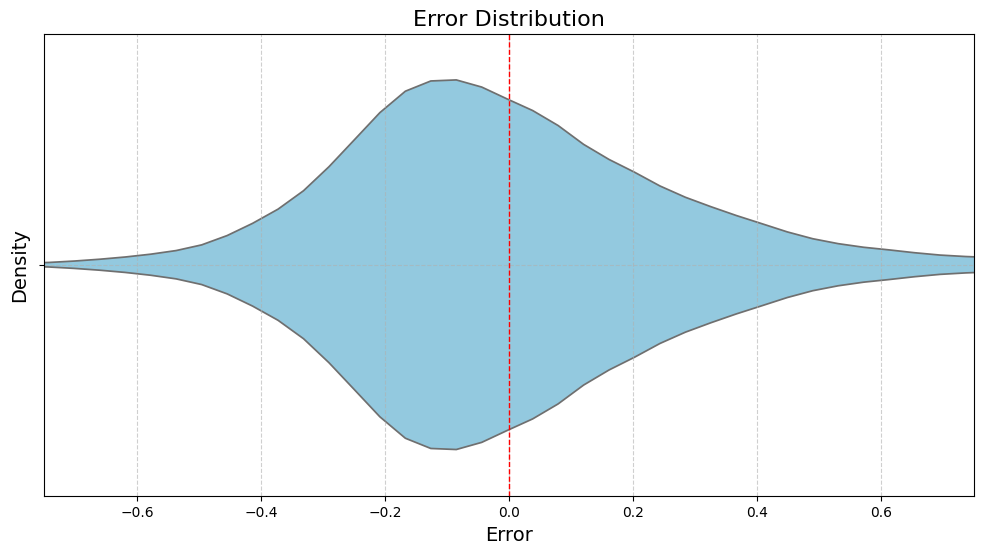

In [40]:
def plot_error():
    # Extract actual and predicted values from the predictions
    actual = [pred.r_ui for pred in predictions]
    predicted = [pred.est for pred in predictions]
    errors = np.array(actual) - np.array(predicted)

    # Plot data
    plt.figure(figsize=(12, 6))
    sns.violinplot(x=errors, color='skyblue', density_norm='width', inner=None)
    plt.axvline(x=0, color='red', linestyle='--', linewidth=1)
    plt.xlim(-0.75, 0.75)

    plt.title('Error Distribution', fontsize=16)
    plt.xlabel('Error', fontsize=14)
    plt.ylabel('Density', fontsize=14)
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.show()

plot_error()

In [41]:
from collections import defaultdict

def precision_recall_at_k(predictions, k, threshold):
    """
    Calculate precision and recall (and F1 score)
    """
    from collections import defaultdict

    user_est_true = defaultdict(list)
    for pred in predictions:
        # (predicted, actual)
        user_est_true[pred.uid].append((pred.est, pred.r_ui))

    precisions = []
    recalls = []
    f1_scores = []

    for uid, user_ratings in user_est_true.items():
        user_ratings.sort(key=lambda x: x[0], reverse=True)
        top_k = user_ratings[:k]

        # Calculate the number of relevant items based on a rating threshold
        n_relevant = sum(1 for (pred, actual) in top_k if actual >= threshold)
        n_relevant_total = sum(1 for (pred, actual) in user_ratings if actual >= threshold)

        precision = n_relevant / k if k > 0 else 0
        recall = n_relevant / n_relevant_total if n_relevant_total > 0 else 0
        precisions.append(precision)
        recalls.append(recall)

        f1 = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
        f1_scores.append(f1)

    avg_precision = sum(precisions) / len(precisions) if precisions else 0
    avg_recall = sum(recalls) / len(recalls) if recalls else 0
    avg_f1 = sum(f1_scores) / len(f1_scores) if f1_scores else 0

    return avg_precision, avg_recall, avg_f1

# Print precision, recall, F1 score for varying k and threshold
for k in [5, 10, 20]:
    for thresh in [0.5, 1.0, 2.0]:
        precision, recall, f1 = precision_recall_at_k(predictions, k, thresh)
        print(f"k={k}, threshold={thresh} -> Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

k=5, threshold=0.5 -> Precision: 0.9850, Recall: 0.5511, F1 Score: 0.6849
k=5, threshold=1.0 -> Precision: 0.9850, Recall: 0.5511, F1 Score: 0.6849
k=5, threshold=2.0 -> Precision: 0.8795, Recall: 0.5260, F1 Score: 0.6279
k=10, threshold=0.5 -> Precision: 0.8740, Recall: 0.9185, F1 Score: 0.8738
k=10, threshold=1.0 -> Precision: 0.8740, Recall: 0.9185, F1 Score: 0.8738
k=10, threshold=2.0 -> Precision: 0.7810, Recall: 0.8794, F1 Score: 0.7953
k=20, threshold=0.5 -> Precision: 0.4922, Recall: 1.0000, F1 Score: 0.6457
k=20, threshold=1.0 -> Precision: 0.4922, Recall: 1.0000, F1 Score: 0.6457
k=20, threshold=2.0 -> Precision: 0.4395, Recall: 0.9565, F1 Score: 0.5832


In [42]:
def get_recommendations(user_id, n_recommendations=5, threshold=0.75):
    """
    Generate top n artist recommendations for a given user
    """
    all_artists = user_artists['artistID'].unique()
    predictions = [model.predict(user_id, artist_id) for artist_id in all_artists]
    filtered_predictions = [pred for pred in predictions if pred.est >= threshold]
    filtered_predictions.sort(key=lambda k: k.est, reverse=True)
    top_artists = [pred.iid for pred in filtered_predictions[:n_recommendations]]
    recommended_artists = artists[artists['id'].isin(top_artists)]['name'].tolist()

    return recommended_artists

user_id = 2
recommendations = get_recommendations(user_id)
print(f"Top recommendations for user {user_id}: {recommendations}")

Top recommendations for user 2: ['Beyoncé', 'Provision', 'Avenged Sevenfold', 'Derdian', 'Chelsie Boyd']
